In [16]:
from pathlib import Path
import json
import numpy as np

# Project root: repo_root/notebooks/01_generate_shapes_images.ipynb
ROOT = Path("..").resolve()

# Choose ONE input:
# INPUT = ROOT / "data" / "mats" / "dog_343_occ.mat"
# INPUT = ROOT / "data" / "mats" / "master_lib.mat"
CASE = "dog_5"

GENERATED_MAT = ROOT / "data" / "cases" / CASE / "generated" / f"{CASE}.jsonl"   # example
MASTER_LIB    = ROOT / "data" / "master" / "master_lib.mat" 

OUT_DIR = ROOT / "data" / "cases" / CASE
WITH_OCC_DIR = OUT_DIR 
NO_OCC_DIR = OUT_DIR 
RAND_DIR = OUT_DIR / "generated" / "completions"

for d in [WITH_OCC_DIR, NO_OCC_DIR, RAND_DIR]:
    d.mkdir(parents=True, exist_ok=True)

H = 600
W = 900
MARGIN = 5
SUPERSAMPLE = 4

SEED = 1000083
rng = np.random.default_rng(SEED)

print("ROOT:", ROOT)
print("INPUT:", GENERATED_MAT)
print("OUT_DIR:", OUT_DIR)

import sys
sys.path.append(str(ROOT / "scripts"))

from shape_gen.io_mat import load_generated_case, unit_to_pixel


def load_case_from_jsonl(jsonl_path: Path, *, line_index: int = -1, default_baseGrid: int = 256):
    """
    Accepts TWO JSONL schemas:

    A) Pipeline schema (preferred):
       silhouette_u, occluder_u, baseGrid, sil_class

    B) Your current schema:
       shape_contour_xy, occluder_rect_xy, (optional) coord_system, (optional) H/W
       . We'll treat these as unit coords and set baseGrid = default_baseGrid unless present.
    """
    lines = jsonl_path.read_text(encoding="utf-8").splitlines()
    if not lines:
        raise ValueError(f"Empty JSONL: {jsonl_path}")
    row = json.loads(lines[line_index])

    # --- Schema A ---
    if "silhouette_u" in row:
        silhouette_u = np.asarray(row["silhouette_u"], dtype=np.float64)
        occluder_u = np.asarray(row.get("occluder_u", []), dtype=np.float64)
        baseGrid = int(row["baseGrid"])
        sil_class = row.get("sil_class", None)

        if occluder_u.size == 0:
            occluder_u = np.zeros((0, 2), dtype=np.float64)

        return silhouette_u, occluder_u, baseGrid, sil_class, row

    # --- Schema B (your current JSONL) ---
    if "shape_contour_xy" in row:
        silhouette_u = np.asarray(row["shape_contour_xy"], dtype=np.float64)
        occluder_u = np.asarray(row.get("occluder_rect_xy", []), dtype=np.float64)

        # Use baseGrid if present, else fall back.
        baseGrid = int(row.get("baseGrid", default_baseGrid))

        # Optional: if your JSONL stores H/W, you might want baseGrid=H (if square)
        if "H" in row and "W" in row and int(row["H"]) == int(row["W"]):
            baseGrid = int(row.get("baseGrid", row["H"]))

        sil_class = row.get("sil_class", row.get("category", None))

        if occluder_u.size == 0:
            occluder_u = np.zeros((0, 2), dtype=np.float64)

        return silhouette_u, occluder_u, baseGrid, sil_class, row

    raise KeyError(
        f"JSONL row missing expected keys. Found keys: {sorted(row.keys())}. "
        f"Expected either 'silhouette_u' or 'shape_contour_xy'."
    )


def load_case_unified(input_path: Path):
    """
    Returns:
      silhouette_u, occluder_u, baseGrid, sil_class, meta(dict)
    """
    input_path = Path(input_path)

    if input_path.suffix.lower() == ".jsonl":
        silhouette_u, occluder_u, baseGrid, sil_class, meta = load_case_from_jsonl(input_path)
        meta["source_type"] = "jsonl"
        return silhouette_u, occluder_u, baseGrid, sil_class, meta

    if input_path.suffix.lower() == ".mat":
        # generated case .mat (your existing format)
        case = load_generated_case(input_path)
        meta = {"source_type": "mat", "source_mat": str(input_path)}

        silhouette_u = case.silhouette_u
        occluder_u = case.occluder_u
        baseGrid = case.base_grid
        sil_class = case.sil_class

        return silhouette_u, occluder_u, baseGrid, sil_class, meta

    raise ValueError(f"Unsupported input type: {input_path.suffix}")


silhouette_u, occluder_u, baseGrid, sil_class, meta = load_case_unified(GENERATED_MAT)

silhouette = unit_to_pixel(silhouette_u, baseGrid)
occluder = unit_to_pixel(occluder_u, baseGrid) if occluder_u.size else np.zeros((0, 2), dtype=np.int32)

print("meta:", meta)
print("baseGrid:", baseGrid)
print("silhouette_u:", silhouette_u.shape, float(np.min(silhouette_u)), float(np.max(silhouette_u)))
print("occluder_u:", occluder_u.shape)
print("silhouette:", silhouette.shape, silhouette.dtype)
print("occluder:", occluder.shape, occluder.dtype)
print("sil_class:", sil_class)


ROOT: /Users/I743312/Documents/monte-carlo-selection
INPUT: /Users/I743312/Documents/monte-carlo-selection/data/cases/dog_5/generated/dog_5.jsonl
OUT_DIR: /Users/I743312/Documents/monte-carlo-selection/data/cases/dog_5
meta: {'ts_utc': 1769278711.098901, 'source_mat': '/Users/I743312/Documents/monte-carlo-selection/data/master/master_lib.mat', 'category': 'dog', 'img_id': 5, 'coord_system': 'normalized_contour_space', 'shape_contour_xy': [[0.15998520759279092, 0.03307559027656315], [0.16555426414226057, 0.04725217330439513], [0.17148244842309152, 0.061280000755272936], [0.17297967287488694, 0.07714319186166768], [0.17641649316848987, 0.09220297606486332], [0.1785487294243566, 0.10780313666974475], [0.18135053791388817, 0.12312595137445374], [0.1851301995035679, 0.13804372606307277], [0.1960167701443259, 0.14893029670383087], [0.20165278391716213, 0.1619917192092934], [0.2080577239408026, 0.17582206796556016], [0.21196306872117493, 0.19068778297203207], [0.21381942090433154, 0.206402218

In [17]:
from shape_gen.geom_bbox import compute_bbox

polys_for_bbox = [silhouette]
if occluder.size:
    polys_for_bbox.append(occluder)

minX, minY, wBB, hBB = compute_bbox(
    polys_for_bbox,
    base_grid=baseGrid,
    margin=MARGIN
)

print(f"Bounding box -> minX={minX}, minY={minY}, wBB={wBB}, hBB={hBB}, baseGrid={baseGrid}")


Bounding box -> minX=37, minY=1, wBB=163, hBB=256, baseGrid=256


In [20]:
from shape_gen.render import draw_and_save

silhouette_index = 1

imgA = WITH_OCC_DIR / "occluded.png"
imgB = NO_OCC_DIR / "gt.png"

# Silhouette only
draw_and_save(
    polygons=[silhouette],
    colors=[[0, 0, 0]],
    minX=minX, minY=minY, wBB=wBB, hBB=hBB,
    out_w=W, out_h=H,
    out_file=imgB,
    supersample=SUPERSAMPLE
)

# Silhouette + occluder
if occluder.size:
    draw_and_save(
        polygons=[silhouette, occluder],
        colors=[[0, 0, 0], [131, 131, 131]],
        minX=minX, minY=minY, wBB=wBB, hBB=hBB,
        out_w=W, out_h=H,
        out_file=imgA,
        supersample=SUPERSAMPLE
    )
else:
    print("Occluder is empty. Skipping silhouette+occluder image.")

print("Wrote:", imgB)
if occluder.size:
    print("Wrote:", imgA)


Wrote: /Users/I743312/Documents/monte-carlo-selection/data/cases/dog_5/gt.png
Wrote: /Users/I743312/Documents/monte-carlo-selection/data/cases/dog_5/occluded.png


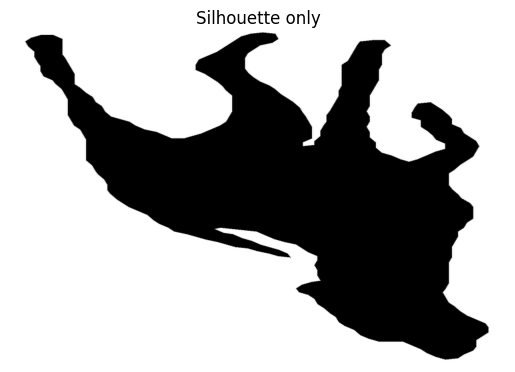

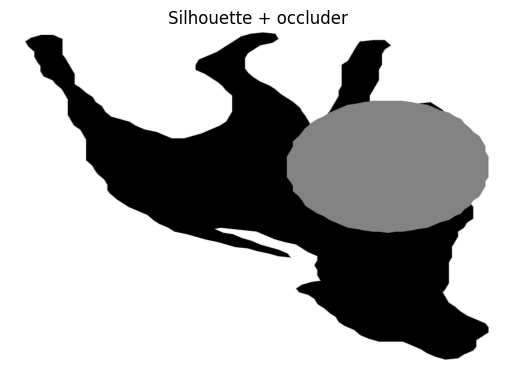

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

def show(path, title):
    im = Image.open(path)
    plt.figure()
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")
    plt.show()

show(imgB, "Silhouette only")
if occluder.size:
    show(imgA, "Silhouette + occluder")


In [13]:
from shape_gen.intersections2 import find_intersection_points_multiple

intersection_points = np.zeros((0, 2), dtype=np.float64)
start_pt = None
end_pt = None

if occluder.size:
    intersection_points = find_intersection_points_multiple(silhouette, occluder, eps_merge=1e-3)

    print("intersection_points shape:", intersection_points.shape)
    print(intersection_points)

    if intersection_points.shape[0] < 2:
        raise RuntimeError("No valid intersection points between silhouette and occluder.")

    start_pt = intersection_points[0, :]
    end_pt = intersection_points[1, :]

    print("start_pt:", start_pt, "end_pt:", end_pt)
else:
    print("Occluder empty. Skipping intersections.")


intersection_points shape: (2, 2)
[[188.28571429 134.85714286]
 [155.          55.33333333]]
start_pt: [188.28571429 134.85714286] end_pt: [155.          55.33333333]


In [14]:
import shape_gen.library as lib
import importlib
importlib.reload(lib)

from shape_gen.library import load_master_records, build_class_index

records = load_master_records(MASTER_LIB)
classes, byClass = build_class_index(records)

print("Loaded records:", len(records))
print("Num classes:", len(classes))
print("Example classes:", classes[:10])


Loaded records: 54000
Num classes: 54
Example classes: ['ant', 'bat', 'bear', 'bee', 'beetle', 'bird', 'bug', 'bull', 'butterfly', 'camel']


In [ ]:
from shape_gen.generate3 import generate_completions, save_metadata_jsonl
from shape_gen.heatmap.xy_store import save_xy_npz

# -------------------------------------------------
# Output locations
# -------------------------------------------------
COMPLETIONS_DIR = RAND_DIR
nImages = 10_000   # scale to 100_000 once validated

# -------------------------------------------------
# Run generator (DONOR-BASED, NATURAL SHAPES)
# -------------------------------------------------
metas, out_files_xy, polygons_xy = generate_completions(
    silhouette=silhouette,
    occluder=occluder,
    start_pt=start_pt,
    end_pt=end_pt,
    minX=minX,
    minY=minY,
    wBB=wBB,
    hBB=hBB,
    out_w=W,
    out_h=H,
    out_dir=COMPLETIONS_DIR,
    silhouette_index=1,
    sil_class=sil_class,
    base_grid=baseGrid,
    records=records,
    classes=classes,
    byClass=byClass,
    n_images=nImages,
    rng=rng,
    # refit_enabled=False,
    # snap_intersections_to_vertices=True,
    # --- donor segment sampling ---
    fraction=0.40,              # length of donor fragment

    # --- donor-fit behavior (core inductive bias) ---
    final_n_samples_mode="match_segment",  # preserves donor geometry
    max_attempts_per_image=100,             # resample donors if invalid
    require_valid=True,

    # --- rendering / bookkeeping ---
    supersample=SUPERSAMPLE,
    flush_every=200,
)

# -------------------------------------------------
# Save metadata (JSONL)
# -------------------------------------------------
meta_path = OUT_DIR / "shapes_meta.jsonl"
save_metadata_jsonl(metas, meta_path)

# -------------------------------------------------
# Save XY polygons aligned to inference order
# -------------------------------------------------
xy_path = OUT_DIR / "shapes_xy.npz"
save_xy_npz(
    xy_path,
    out_files=out_files_xy,
    polygons=polygons_xy,
    base_grid=int(baseGrid),
    matlab_1_indexed=True,
)

print("Saved metadata:", meta_path)
print("Saved XY pack:", xy_path)
print("Valid completions saved:", len(out_files_xy))
print("Total meta rows:", len(metas))


Generated 200/10000 completions... (last attempts=2)
Generated 400/10000 completions... (last attempts=3)
Generated 600/10000 completions... (last attempts=1)
Generated 800/10000 completions... (last attempts=3)
Generated 1000/10000 completions... (last attempts=1)
Generated 1200/10000 completions... (last attempts=3)
Generated 1400/10000 completions... (last attempts=1)
Generated 1600/10000 completions... (last attempts=2)
Generated 1800/10000 completions... (last attempts=1)
Generated 2000/10000 completions... (last attempts=9)
Generated 2200/10000 completions... (last attempts=1)
Generated 2400/10000 completions... (last attempts=1)
Generated 2600/10000 completions... (last attempts=1)
Generated 2800/10000 completions... (last attempts=2)
Generated 3000/10000 completions... (last attempts=2)
Generated 3200/10000 completions... (last attempts=5)
Generated 3400/10000 completions... (last attempts=5)
Generated 3600/10000 completions... (last attempts=3)
Generated 3800/10000 completions

# Parallel Version

In [ ]:
# =========================
# NEW: parallel wrapper cell (8 cores, 10k attempts)
# =========================
# Put this in your notebook cell. It assumes you already have all inputs defined as in your current cell.
# It writes worker outputs into OUT_DIR/_tmp_parallel, then merges to shapes_meta.jsonl and shapes_xy.npz.

from __future__ import annotations

import os
import re
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np

from shape_gen.generate_parallel import generate_completions, save_metadata_jsonl
from shape_gen.heatmap.xy_store import save_xy_npz


def _worker_run(args: dict) -> dict:
    """
    Runs one worker range. Returns paths to worker outputs.
    """
    wid = int(args["worker_id"])
    out_dir = Path(args["out_dir"])
    tmp_dir = Path(args["tmp_dir"])
    tmp_dir.mkdir(parents=True, exist_ok=True)

    # Per-worker RNG
    seed = int(args["seed"])
    rng = np.random.default_rng(seed)

    metas, out_files_xy, polygons_xy = generate_completions(
        silhouette=args["silhouette"],
        occluder=args["occluder"],
        start_pt=args["start_pt"],
        end_pt=args["end_pt"],
        minX=int(args["minX"]),
        minY=int(args["minY"]),
        wBB=int(args["wBB"]),
        hBB=int(args["hBB"]),
        out_w=int(args["out_w"]),
        out_h=int(args["out_h"]),
        out_dir=out_dir,
        silhouette_index=int(args["silhouette_index"]),
        sil_class=str(args["sil_class"]),
        base_grid=int(args["base_grid"]),
        records=args["records"],
        classes=args["classes"],
        byClass=args["byClass"],
        n_images=int(args["n_attempts"]),
        rng=rng,
        start_index=int(args["start_index"]),
        fraction=float(args["fraction"]),
        final_n_samples_mode=str(args["final_n_samples_mode"]),
        supersample=int(args["supersample"]),
        flush_every=int(args["flush_every"]),
        max_attempts_per_image=int(args["max_attempts_per_image"]),
        require_valid=bool(args["require_valid"]),
        snap_intersections_to_vertices=bool(args["snap_intersections_to_vertices"]),
        refit_enabled=bool(args["refit_enabled"]),
        refit_n_ctrl=int(args["refit_n_ctrl"]),
        refit_subdiv=int(args["refit_subdiv"]),
        refit_jitter_sigma=float(args["refit_jitter_sigma"]),
        refit_max_attempts=int(args["refit_max_attempts"]),
        shrink_gamma=float(args["shrink_gamma"]),
        max_shrink_iters=int(args["max_shrink_iters"]),
        smooth_win=int(args["smooth_win"]),
        try_mirror=bool(args["try_mirror"]),
        save_invalid=bool(args["save_invalid"]),
        invalid_subdir=str(args["invalid_subdir"]),
    )

    meta_path = tmp_dir / f"meta_worker_{wid:02d}.jsonl"
    save_metadata_jsonl(metas, meta_path)

    xy_path = tmp_dir / f"xy_worker_{wid:02d}.npz"
    # Save worker-local XY pack. This is not the final shapes_xy.npz yet.
    save_xy_npz(
        xy_path,
        out_files=out_files_xy,
        polygons=polygons_xy,
        base_grid=int(args["base_grid"]),
        matlab_1_indexed=True,
    )

    return {
        "worker_id": wid,
        "meta_path": str(meta_path),
        "xy_path": str(xy_path),
        "valid_count": int(len(out_files_xy)),
        "attempts": int(args["n_attempts"]),
        "start_index": int(args["start_index"]),
    }


def _extract_completion_index_from_path(p: str) -> int:
    """
    Expects filenames like completion_0001_01234.png and returns 1234.
    """
    m = re.search(r"completion_\d{4}_(\d{5})\.png$", str(p))
    if not m:
        raise ValueError(f"Could not parse completion index from: {p}")
    return int(m.group(1))


# -------------------------
# Settings
# -------------------------
N_WORKERS = 8
TOTAL_ATTEMPTS = 10_000
ATTEMPTS_PER = TOTAL_ATTEMPTS // N_WORKERS
assert ATTEMPTS_PER * N_WORKERS == TOTAL_ATTEMPTS

BASE_SEED = 12345

COMPLETIONS_DIR = RAND_DIR  # as in your cell
OUT_TMP = OUT_DIR / "_tmp_parallel"
OUT_TMP.mkdir(parents=True, exist_ok=True)

# If you want fewer print lines from workers, increase flush_every.
FLUSH_EVERY_WORKER = 1000

# -------------------------
# Build worker jobs
# -------------------------
jobs = []
for wid in range(N_WORKERS):
    start_i = wid * ATTEMPTS_PER + 1
    seed = BASE_SEED + wid

    jobs.append(
        dict(
            worker_id=wid,
            seed=seed,
            tmp_dir=str(OUT_TMP),
            out_dir=str(COMPLETIONS_DIR),

            # all your shared inputs
            silhouette=silhouette,
            occluder=occluder,
            start_pt=start_pt,
            end_pt=end_pt,
            minX=minX,
            minY=minY,
            wBB=wBB,
            hBB=hBB,
            out_w=W,
            out_h=H,
            silhouette_index=1,
            sil_class=sil_class,
            base_grid=baseGrid,
            records=records,
            classes=classes,
            byClass=byClass,

            # range control
            n_attempts=ATTEMPTS_PER,
            start_index=start_i,

            # generator settings, mirror your current call
            fraction=0.40,
            final_n_samples_mode="match_segment",
            supersample=SUPERSAMPLE,
            flush_every=FLUSH_EVERY_WORKER,
            max_attempts_per_image=100,
            require_valid=True,
            save_invalid=False,
            invalid_subdir="_invalid",
            snap_intersections_to_vertices=True,

            refit_enabled=True,
            refit_n_ctrl=14,
            refit_subdiv=25,
            refit_jitter_sigma=0.015,
            refit_max_attempts=10,

            shrink_gamma=0.88,
            max_shrink_iters=30,
            smooth_win=5,
            try_mirror=True,
        )
    )

# -------------------------
# Run in parallel
# -------------------------
results = []
with ProcessPoolExecutor(max_workers=N_WORKERS) as ex:
    futs = [ex.submit(_worker_run, j) for j in jobs]
    for fut in as_completed(futs):
        results.append(fut.result())

results = sorted(results, key=lambda d: d["worker_id"])
print("Workers finished.")
for r in results:
    print(f"worker {r['worker_id']:02d}. attempts={r['attempts']}. valid={r['valid_count']}. start={r['start_index']}")

# -------------------------
# Merge metadata JSONL
# -------------------------
all_meta_lines = []
for r in results:
    meta_path = Path(r["meta_path"])
    all_meta_lines.extend(meta_path.read_text(encoding="utf-8").splitlines())

# Sort meta lines by completion_index for stable order.
# This is a lightweight parse. If you prefer, parse JSON fully then sort.
import json as _json
meta_rows = [_json.loads(line) for line in all_meta_lines if line.strip()]
meta_rows.sort(key=lambda d: int(d.get("completion_index", 0)))

meta_path = OUT_DIR / "shapes_meta.jsonl"
meta_path.parent.mkdir(parents=True, exist_ok=True)
with meta_path.open("w", encoding="utf-8") as f:
    for row in meta_rows:
        f.write(_json.dumps(row) + "\n")

print("Saved metadata:", meta_path)

# -------------------------
# Merge XY packs
# -------------------------
all_out_files = []
all_polygons = []

for r in results:
    npz = np.load(r["xy_path"], allow_pickle=True)
    # xy_store.save_xy_npz typically stores arrays under these keys.
    # If your keys differ, print(npz.files) once and adjust.
    out_files = npz["out_files"].tolist()
    polys = npz["polygons"]

    all_out_files.extend([str(p) for p in out_files])
    all_polygons.extend([polys[i] for i in range(polys.shape[0])])

# Sort valid outputs by completion index extracted from filename.
pairs = list(zip(all_out_files, all_polygons))
pairs.sort(key=lambda t: _extract_completion_index_from_path(t[0]))

out_files_xy = [p[0] for p in pairs]
polygons_xy = [p[1] for p in pairs]

xy_path = OUT_DIR / "shapes_xy.npz"
save_xy_npz(
    xy_path,
    out_files=out_files_xy,
    polygons=polygons_xy,
    base_grid=int(baseGrid),
    matlab_1_indexed=True,
)

print("Saved XY pack:", xy_path)
print("Valid completions saved:", len(out_files_xy))
print("Total meta rows:", len(meta_rows))


In [ ]:
# =========================
# OPTIONAL: exact-10k-valid top-up
# =========================
# If you require exactly 10,000 valid completions, you can top up missing valids after the parallel run.
# This keeps ordering by using new start indices that come after the last used index.

NEEDED_VALID = 10_000
if len(out_files_xy) < NEEDED_VALID:
    missing = NEEDED_VALID - len(out_files_xy)
    print("Missing valid completions:", missing)

    # Run serial top-up. Simple and reliable.
    # It appends new indices starting after TOTAL_ATTEMPTS.
    topup_rng = np.random.default_rng(BASE_SEED + 999)

    topup_metas, topup_out_files, topup_polys = generate_completions(
        silhouette=silhouette,
        occluder=occluder,
        start_pt=start_pt,
        end_pt=end_pt,
        minX=minX,
        minY=minY,
        wBB=wBB,
        hBB=hBB,
        out_w=W,
        out_h=H,
        out_dir=COMPLETIONS_DIR,
        silhouette_index=1,
        sil_class=sil_class,
        base_grid=baseGrid,
        records=records,
        classes=classes,
        byClass=byClass,
        n_images=missing * 2,            # attempt budget. adjust if your valid rate is low
        rng=topup_rng,
        start_index=TOTAL_ATTEMPTS + 1,  # ensures no collisions
        fraction=0.40,
        final_n_samples_mode="match_segment",
        supersample=SUPERSAMPLE,
        flush_every=1000,
        max_attempts_per_image=100,
        require_valid=True,
        snap_intersections_to_vertices=True,
        refit_enabled=True,
    )

    # Merge meta
    topup_rows = [__import__("json").loads(__import__("json").dumps(asdict(m))) for m in topup_metas]
    meta_rows.extend(topup_rows)
    meta_rows.sort(key=lambda d: int(d.get("completion_index", 0)))
    with meta_path.open("w", encoding="utf-8") as f:
        for row in meta_rows:
            f.write(__import__("json").dumps(row) + "\n")

    # Merge xy
    pairs2 = list(zip(topup_out_files, topup_polys))
    pairs.extend(pairs2)
    pairs.sort(key=lambda t: _extract_completion_index_from_path(t[0]))
    out_files_xy = [p[0] for p in pairs][:NEEDED_VALID]
    polygons_xy = [p[1] for p in pairs][:NEEDED_VALID]

    save_xy_npz(
        xy_path,
        out_files=out_files_xy,
        polygons=polygons_xy,
        base_grid=int(baseGrid),
        matlab_1_indexed=True,
    )

    print("Topped up. Valid completions saved:", len(out_files_xy))


In [23]:
# UTILITY . Cell: flip all images in data/generated_images/random_segments by 180 degrees
# (i.e., rotate 180°). Overwrites images by default.
#
# Supported formats: png, jpg, jpeg, bmp, tif, tiff, webp

from pathlib import Path
from PIL import Image

ROOT = Path.cwd().parent  # adjust if needed
IMG_DIR = ROOT / "data" / "generated_images_ant_107" / "completions"

if not IMG_DIR.exists():
    raise FileNotFoundError(f"Directory not found: {IMG_DIR}")

EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

paths = [p for p in IMG_DIR.iterdir() if p.is_file() and p.suffix.lower() in EXTS]
print(f"Found {len(paths)} images in {IMG_DIR}")

for p in paths:
    try:
        with Image.open(p) as im:
            # rotate 180° (equivalent to flipping both axes)
            im_rot = im.rotate(180, expand=False)
            im_rot.save(p)
    except Exception as e:
        print(f"Failed on {p.name}: {e}")

print("Done. All images rotated by 180°.")


Found 10000 images in /Users/I743312/Documents/occlusion-study/data/generated_images_ant_107/completions
Done. All images rotated by 180°.
